In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from models.networks import UNetRes
import peft
from utils import get_dataloader
from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio


c:\Users\leons\AppData\Local\miniconda3\envs\leon_torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
full_model = UNetRes(in_nc=3+1, out_nc=3, nc=[64, 128, 256, 512], nb=4, act_mode='R', downsample_mode="strideconv", upsample_mode="convtranspose").to('cuda')
full_model.load_state_dict(torch.load('weights/rankfull/model/model.pth'))

full_full = UNetRes(in_nc=3+1, out_nc=3, nc=[64, 128, 256, 512], nb=4, act_mode='R', downsample_mode="strideconv", upsample_mode="convtranspose").to('cuda')
full_full.load_state_dict(torch.load('weights/full/model/model.pth'))

rank8 = UNetRes(in_nc=3+1, out_nc=3, nc=[64, 128, 256, 512], nb=4, act_mode='R', downsample_mode="strideconv", upsample_mode="convtranspose").to('cuda')
rank6 = UNetRes(in_nc=3+1, out_nc=3, nc=[64, 128, 256, 512], nb=4, act_mode='R', downsample_mode="strideconv", upsample_mode="convtranspose").to('cuda')
rank4 = UNetRes(in_nc=3+1, out_nc=3, nc=[64, 128, 256, 512], nb=4, act_mode='R', downsample_mode="strideconv", upsample_mode="convtranspose").to('cuda')

In [3]:
def lora_model(model, rank):
    weights_lora = [(n, type(m)) for n, m in model.named_modules()]
    weights_lora = [(n, m) for n, m in weights_lora if m == torch.nn.modules.conv.Conv2d]
    weights_lora = [n for n, m in weights_lora]

    config = peft.LoraConfig(
        r=rank,
        target_modules=weights_lora,
    )

    return peft.get_peft_model(model, config)

In [4]:
lora8 = lora_model(rank8, 8)
lora6 = lora_model(rank6, 6)
lora4 = lora_model(rank4, 4)

lora8.load_state_dict(torch.load('weights/rank8/model.pth'))
lora6.load_state_dict(torch.load('weights/rank6/model.pth'))
lora4.load_state_dict(torch.load('weights/rank4/model/model.pth'))

<All keys matched successfully>

In [5]:
train_loader, val_loader, test_loader = get_dataloader(1, 0, 'data/dataset_reshaped.npy', (256, 256))

# next iter test_loader

clean, noisy = next(iter(test_loader))
clean = torch.cat((clean, clean, clean), dim=1).to('cuda')
noisy = torch.cat((noisy, noisy, noisy, noisy), dim=1).to('cuda')

In [6]:
out8 = lora8(noisy.to('cuda'))
out6 = lora6(noisy.to('cuda'))
out4 = lora4(noisy.to('cuda'))
outf = full_model(noisy.to('cuda'))
outff = full_full(noisy.to('cuda'))

In [7]:
SSIM = StructuralSimilarityIndexMeasure(data_range=1.0).to('cuda')
PSNR = PeakSignalNoiseRatio(data_range=1.0).to('cuda') 

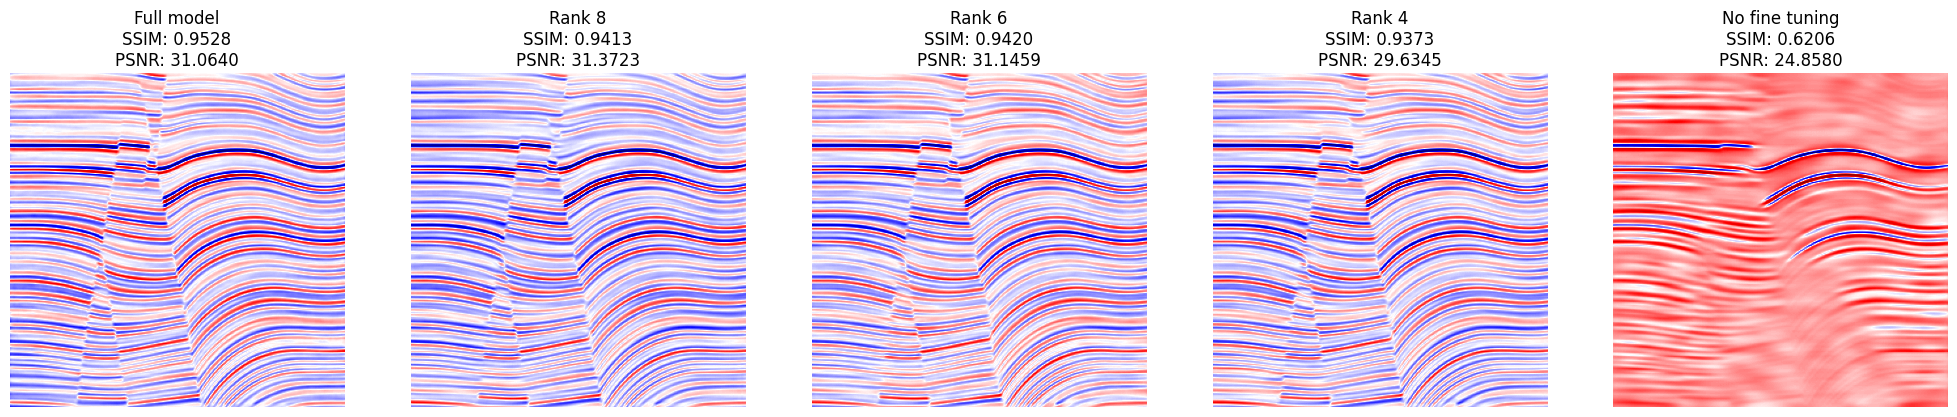

In [8]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
axs[0].imshow(outff[0][0].cpu().detach(), cmap='seismic')
axs[0].set_title(f'Full model\nSSIM: {SSIM(outff, clean):.4f}\nPSNR: {PSNR(outff, clean):.4f}')
axs[0].axis('off')
axs[1].imshow(out8[0][0].cpu().detach(), cmap='seismic')
axs[1].set_title(f'Rank 8\nSSIM: {SSIM(out8, clean):.4f}\nPSNR: {PSNR(out8, clean):.4f}')
axs[1].axis('off')
axs[2].imshow(out6[0][0].cpu().detach(), cmap='seismic')
axs[2].set_title(f'Rank 6\nSSIM: {SSIM(out6, clean):.4f}\nPSNR: {PSNR(out6, clean):.4f}')
axs[2].axis('off')
axs[3].imshow(out4[0][0].cpu().detach(), cmap='seismic')
axs[3].set_title(f'Rank 4\nSSIM: {SSIM(out4, clean):.4f}\nPSNR: {PSNR(out4, clean):.4f}')
axs[3].axis('off')
axs[4].imshow(outf[0][0].cpu().detach(), cmap='seismic')
axs[4].set_title(f'No fine tuning\nSSIM: {SSIM(outf, clean):.4f}\nPSNR: {PSNR(outf, clean):.4f}')
axs[4].axis('off')
plt.show()


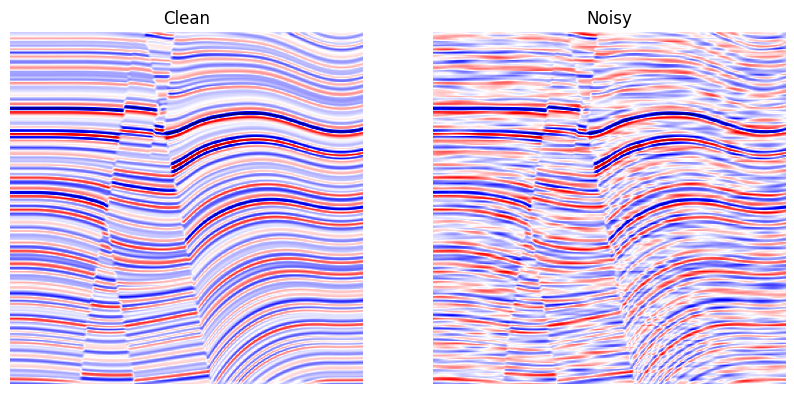

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(clean[0][0].cpu(), cmap='seismic')
axs[0].set_title('Clean')
axs[0].axis('off')
axs[1].imshow(noisy[0][0].cpu(), cmap='seismic')
axs[1].set_title('Noisy')
axs[1].axis('off')
plt.show()